In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import ipynbname
script_dir = os.getcwd()
filename = ipynbname.name()

from sde.SDE_ARFF_lib import (
    SDEARFFTrain,
    NNHyperparameters,
    MeanMinLoss
)

from sde.experiment_reports_owen import (
    sample_data,
    plot_results_functions,
    histogram_data,
    plot_histogram
)

%load_ext autoreload
%autoreload 2

2025-05-28 07:42:16.528245: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-28 07:42:16.532084: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/x86_64-linux-gnu:/usr/local/cuda-12.6/lib64::/usr/lib/x86_64-linux-gnu
2025-05-28 07:42:16.532097: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# notebook parameters
random_seed = 1
step_size = 1e-2
n_pts = 10000

n_dimensions = 1

In [3]:
# EXAMPLE 1
sde_gamma = .5
sde_beta = 10

def true_drift(v, x):
    return (-x**3 - x - sde_gamma * v)

def true_diffusion(v, x):
    return 0*x+np.sqrt(2 * sde_gamma / sde_beta)


def true_drift_diffusion(v, x):
    return true_drift(v, x), true_diffusion(v, x)


rng = np.random.default_rng(random_seed)

vlim = np.array([[-2.5, 2.5]])
xlim = np.array([[-2.5, 2.5]])

# NOTE: we are artificially using "symplectic" Euler here by considering "x_data" as "x(n+1)", not "x(n)"
# However, in "sample_data" x_data is sampled at random anyway, so no changes must be made inside the method.
# Note that in histogram trajectory generation, we generate using x(n+1) = x(n) + h*v(n).

x_data, y_data, p_data = sample_data(true_drift_diffusion,
                             step_size=step_size, n_dimensions=n_dimensions,
                             low=vlim[:,0], high=vlim[:,1], n_pts=n_pts,
                             rng=rng, param_low=xlim[:,0], param_high=xlim[:,1])
x_data_test, y_data_test, p_data_test = sample_data(true_drift_diffusion,
                                       step_size=step_size,
                                       n_dimensions=n_dimensions,
                                       low=vlim[:,0], high=vlim[:,1],
                                       n_pts=n_pts//10, rng=rng,
                                       param_low=xlim[:,0], param_high=xlim[:,1])

step_sizes = np.zeros((x_data.shape[0],)) + step_size

print('data shape', x_data.shape)

data shape (10000, 1)


In [4]:
# network parameters
validation_split = .1
ARFF_validation_split = .1

drift_param = NNHyperparameters(K=2**7, 
                                M_min=20,
                                M_max=200,
                                gamma=1,
                                delta=0.1,
                                name='drift')
diff_param = NNHyperparameters(K=drift_param.K,
                               M_min=drift_param.M_min,
                               M_max=drift_param.M_max,
                               gamma=drift_param.gamma,
                               delta=drift_param.delta,
                               name='diff')


In [5]:
def true_drift(x):
    x = np.atleast_2d(x)
    v = x[:,0]
    x = x[:,1]
    result = (-x**3 - x - sde_gamma * v)
    return result.reshape(-1, 1)

def true_diffusion(x):
    x = np.atleast_2d(x)
    # v = x[:,0]
    # x = x[:,1]
    result = 0*x+ np.sqrt(2 * sde_gamma / sde_beta).reshape(-1)
    return result.reshape(-1, 1)

def true_drift_diffusion(x, p):
    return true_drift(x), true_diffusion(x)

In [6]:
xlim = np.array([[-2.5, 2.5], [-2.5, 2.5]])
MML = MeanMinLoss()
mean_loss, SD, SD_val = MML.get_MML(true_diffusion, n_dimensions, n_pts, validation_split, xlim, step_size)
print('Theoretical mean min loss:', mean_loss)
print('Loss standard deviation:', SD)
print('Validation loss standard deviation:', SD_val)

# output_dir = os.path.join(script_dir, 'loss_data')
# output_path = os.path.join(output_dir, f"MML_{filename}.txt")
# with open(output_path, 'w') as file:
#     file.write(f"{mean_loss}\n")

Theoretical mean min loss: -2.0349391062863957
Loss standard deviation: 0.007453559924999299
Validation loss standard deviation: 0.022360679774997897


drift epoch: 63


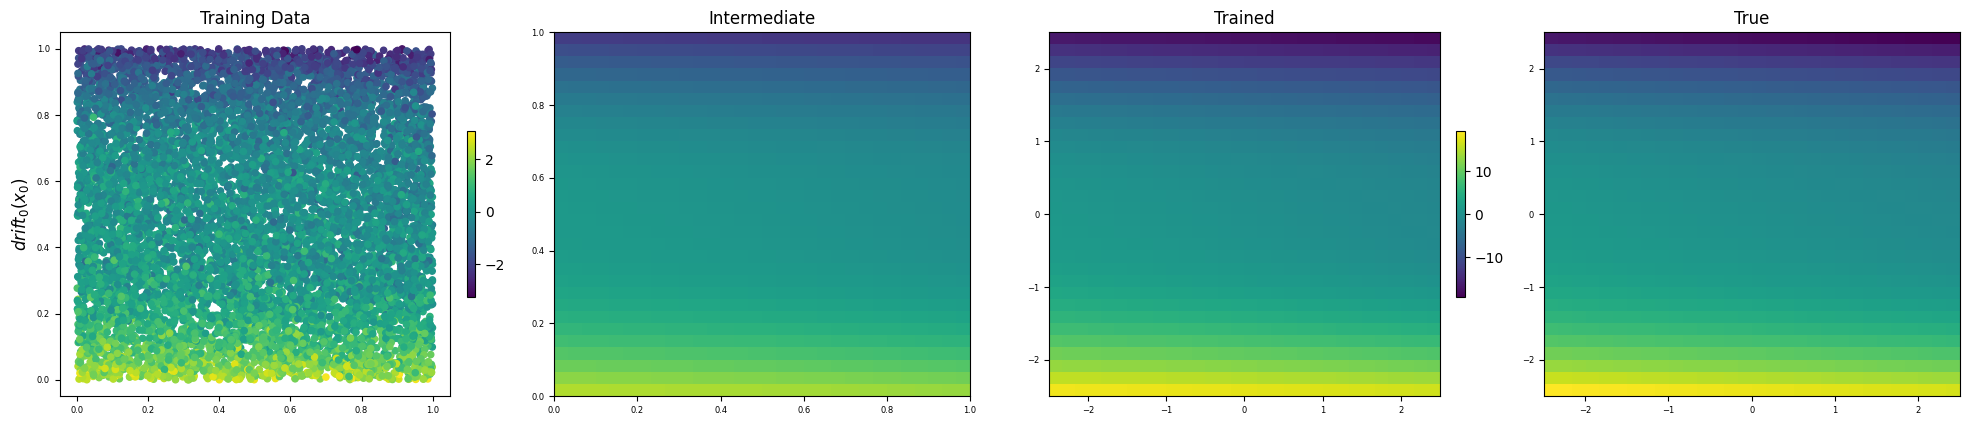

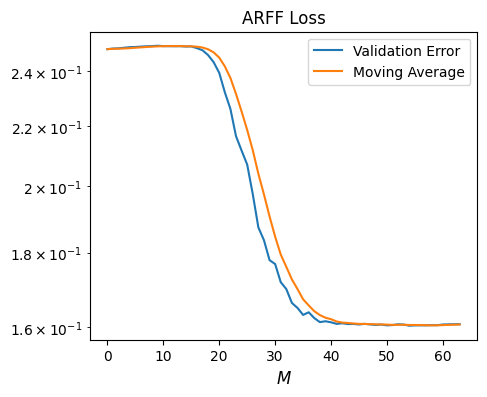

diff epoch: 20


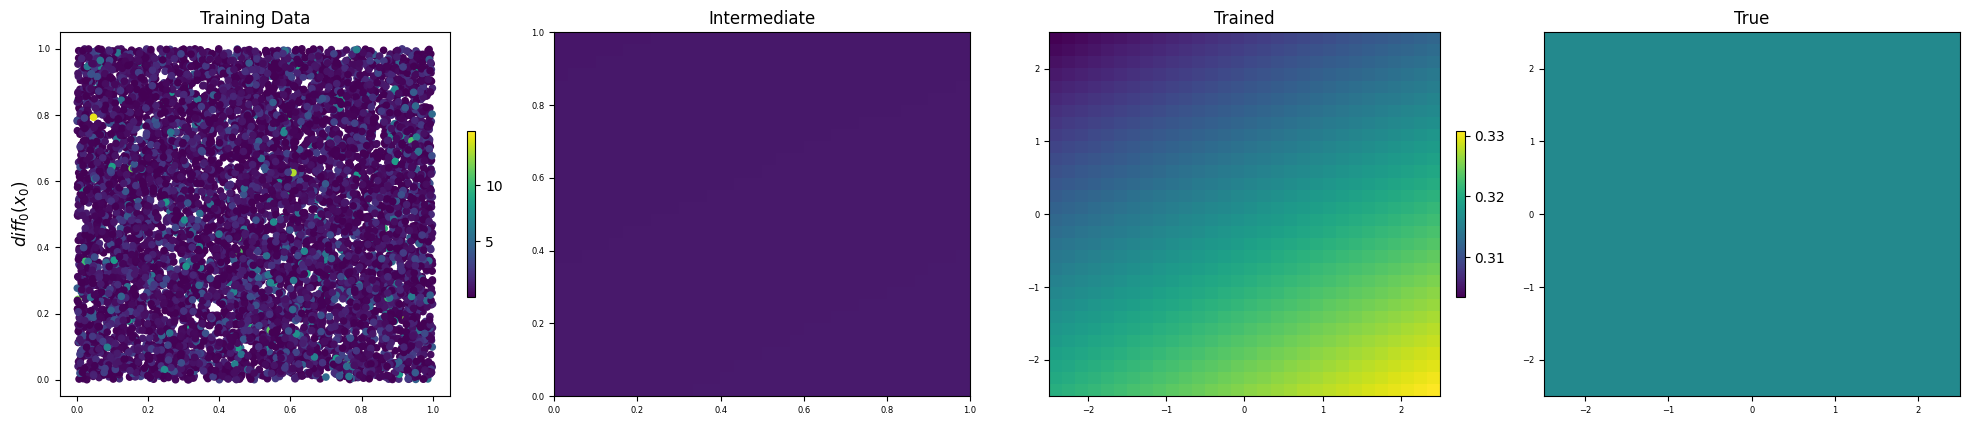

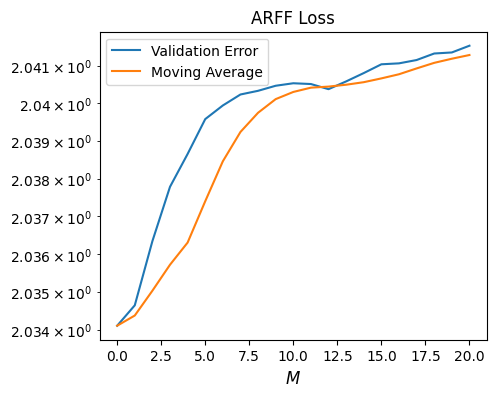

Observed loss: -2.031901436728496
Observed validation loss: -2.029187195984744
True function validation loss: -2.031041723030243
Training time: 11.76679015159607


2025-05-28 07:42:41.695783: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/x86_64-linux-gnu:/usr/local/cuda-12.6/lib64::/usr/lib/x86_64-linux-gnu
2025-05-28 07:42:41.695891: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/x86_64-linux-gnu:/usr/local/cuda-12.6/lib64::/usr/lib/x86_64-linux-gnu
2025-05-28 07:42:41.695957: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/x86_64-linux-gnu:/usr/local/cuda-12.6/lib64::/usr/lib/x86_64-linux-gnu
2025-05-28 07:42:41.

In [7]:
No_of_tests = 1
training_time = np.zeros(No_of_tests)
val_loss = np.zeros(No_of_tests)

for i in range(No_of_tests):
    SAT = SDEARFFTrain(n_dimensions=n_dimensions, resampling=True)
    hist = SAT.train_model(drift_param, diff_param, true_drift, true_diffusion, x_data, y_data, p_data, step_sizes=step_sizes, validation_split=validation_split, ARFF_validation_split=ARFF_validation_split, plot=True)
    training_time[i] = hist.history["training_time"]
    val_loss[i] = hist.history["val_loss"]

/home/douglaoj/miniconda3/envs/SDE_NN/lib/python3.9/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/douglaoj/miniconda3/envs/SDE_NN/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/douglaoj/miniconda3/envs/SDE_NN/lib/python3.9/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/douglaoj/miniconda3/envs/SDE_NN/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1066: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
/home/douglaoj/miniconda3/envs/SDE_NN/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1067: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[..., 0])
/home/douglaoj/miniconda

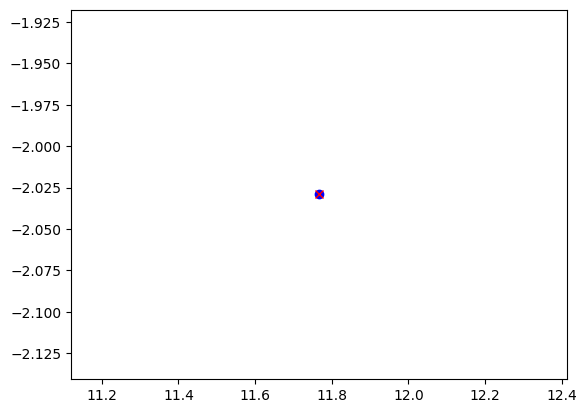

In [8]:
# Calculate the mean
mean_training_time = np.mean(training_time)
mean_val_loss = np.mean(val_loss)

# Calculate the standard deviation above and below the mean for training_time
training_time_above = training_time[training_time > mean_training_time] - mean_training_time
training_time_below = mean_training_time - training_time[training_time < mean_training_time]

std_training_time_above = np.std(np.concatenate((training_time_above, -training_time_above)))
std_training_time_below = np.std(np.concatenate((training_time_below, -training_time_below)))

# Calculate points above and below the mean for val_loss
val_loss_above = val_loss[val_loss > mean_val_loss] - mean_val_loss
val_loss_below = mean_val_loss - val_loss[val_loss < mean_val_loss]

std_val_loss_above = np.std(np.concatenate((val_loss_above, -val_loss_above)))
std_val_loss_below = np.std(np.concatenate((val_loss_below, -val_loss_below)))

# Plot scatter points
plt.scatter(training_time, val_loss, color='blue', label='Data Points')

# Add non-symmetrical error bars (standard deviations)
plt.errorbar(
    mean_training_time, mean_val_loss,
    xerr=[[std_training_time_below], [std_training_time_above]],  # Non-symmetrical x error
    yerr=[[std_val_loss_below], [std_val_loss_above]],  # Non-symmetrical y error
    fmt='x', color='red', ecolor='black', elinewidth=1.5, capsize=4, label='Mean ± STD'
)
plt.show()

# output_dir = os.path.join(script_dir, 'loss_data')
# output_path = os.path.join(output_dir, f"{filename}.txt")
# with open(output_path, 'w') as file:
#     file.write(f"{mean_training_time},{mean_val_loss},{std_training_time_above},{std_training_time_below},{std_val_loss_above},{std_val_loss_below}\n")


In [31]:
def true_drift(x, p):
    v = x[:,0]
    x = x[:,1]
    return (-x**3 - x - sde_gamma * v).reshape(-1, 1)

def true_diffusion(x, p):
    v = x[:,0]
    x = x[:,1]
    return 0*v + np.sqrt(2 * sde_gamma / sde_beta).reshape(-1)

def true_drift_diffusion(x, p):
    return true_drift(x, p), true_diffusion(x, p)

# def true_drift(x):
#     v = x[:,0]
#     x = x[:,1]
#     return (-x**3 - x - sde_gamma * v).reshape(-1, 1)

# def true_diffusion(x):
#     v = x[:,0]
#     x = x[:,1]
#     return 0*v + np.sqrt(2 * sde_gamma / sde_beta).reshape(-1)

# def true_drift_diffusion(x):
#     return true_drift(x), true_diffusion(x)

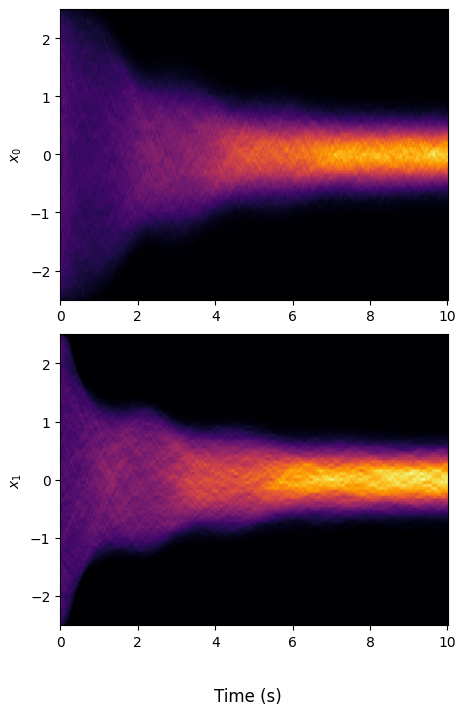

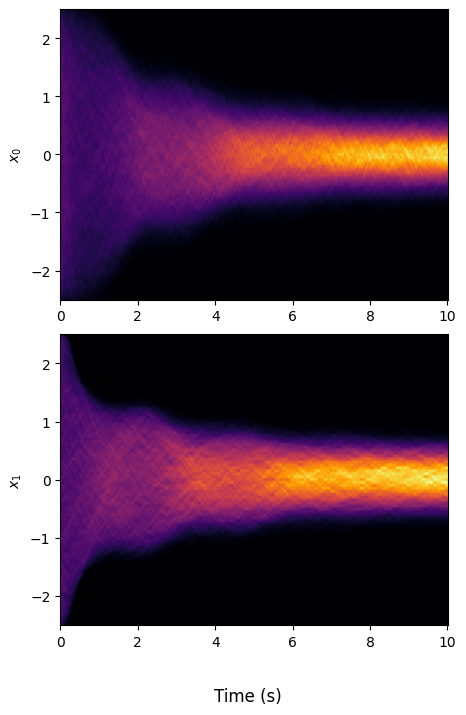

In [46]:
ylim = np.array([[-2.5, 2.5]])
plim = np.array([[-2.5, 2.5]])

def coupled_func(x, p, step_size):
    return p + x*step_size

time = 1000*step_size
# true_paths = histogram_data(true_drift_diffusion, xlim, step_size*10, time, n_dimensions, random_seed+1, Type="coupled")
# ARFF_paths = histogram_data(SAT.drift_diffusion, xlim, step_size*10, time, n_dimensions, random_seed+1, Type="coupled")

true_paths = histogram_data(true_drift_diffusion, step_size, time, n_dimensions, random_seed+1, ylim, plim=plim, coupled_func=coupled_func)
ARFF_paths = histogram_data(SAT.drift_diffusion, step_size, time, n_dimensions, random_seed+1, ylim, plim=plim, coupled_func=coupled_func)

plot_histogram(true_paths, step_size, ylim, plim=plim)
plot_histogram(ARFF_paths, step_size, ylim, plim=plim)

# output_dir = os.path.join(script_dir, 'histogram_data')

# output_path_true = os.path.join(output_dir, f"{filename}_data.txt")
# with open(output_path_true, 'w') as file:
#     file.write(f"{step_size},{xlim}\n")

# output_path_true = os.path.join(output_dir, f"{filename}_true.npy")
# np.save(output_path_true, true_paths)

# output_path_ARFF = os.path.join(output_dir, f"{filename}_ARFF.npy")
# np.save(output_path_ARFF, ARFF_paths)

In [29]:
def true_drift(v, x):
    return (-x**3 - x - sde_gamma * v)

def true_diffusion(v, x):
    return 0*x+np.sqrt(2 * sde_gamma / sde_beta)


def true_drift_diffusion(v, x):
    return true_drift(v, x), true_diffusion(v, x)

rng = np.random.default_rng(random_seed)

idx_p = np.argsort(p_data_test.ravel())

fig, ax = plot_parameter_functions(SAT.drift_diffusion, true_drift_diffusion,
                                    x_data_test[idx_p,:], None, None,
                                    p_data=p_data_test[idx_p,:])

ax[1].set_ylim([0, .5])
ax[0].set_xlabel(r'$x_1$', fontsize=11)
ax[1].set_xlabel(r'$x_1$', fontsize=11)
plt.gcf().tight_layout()

# output_dir = os.path.join(script_dir, 'trained_vs_true_plots')
# output_path = os.path.join(output_dir, f"{filename}")
# plt.savefig(output_path, dpi=300, bbox_inches='tight')

NameError: name 'plot_parameter_functions' is not defined

## Now we try it "the agnostic way", with the same data but assuming that there is a noise influence for q as well

In [22]:
T_steps = int(20 / step_size)
N_iterates = 1
random_seed = 1
rng = np.random.default_rng(random_seed)

time_steps, paths_network = \
    generate_results_nongaussian(SAT.drift_diffusivity, step_size, x_data, rng, p_data=p_data, T_steps=T_steps, N_iterates=N_iterates);

rng = np.random.default_rng(random_seed)
time_steps, paths_true = \
    generate_results_nongaussian(true_drift_diffusivity, step_size, x_data, rng, p_data=p_data, T_steps=T_steps, N_iterates=N_iterates);

# only plot the q trajectory
paths_true = [paths_true[i][:, :1] for i in range(len(paths_true))]
paths_network = [paths_network[i][:, :1] for i in range(len(paths_true))]

plot_results_1d(time_steps, paths_network, paths_true, plot_dim=0, linewidth=.5, figsize=(5, 3));
plt.gca().set_ylim([-1, 1])
plt.gca().set_ylabel(r"$q(t)$");
plt.gca().legend(['Path with network', 'Path with SDE'])

plt.gcf().savefig("figures/example8_nongaussian_path_convergence.pdf")
plt.gcf().savefig("figures/example8_nongaussian_path_convergence.png")

NameError: name 'generate_results_nongaussian' is not defined

In [59]:
import matplotlib.pyplot as plt
import numpy as np

from sde.SDE_AM_lib_no_iteration import (
    SDEAMTrain,
    NNHyperparameters
)

from sde.experiment_reports import (
    sample_data,
    plot_results_functions,
    plot_parameter_functions,
    generate_results,
    plot_results_1d,
    probability_density
)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
# notebook parameters
random_seed = 1
step_size = 1e-2
n_pts = 10000

n_dimensions = 2

In [82]:
def f_1(x):
    A = 0
    B = np.array([[0], [1]])
    C = np.array([[0], [0]])
    D = np.array([[0], [0]])
    f = np.squeeze(A + np.dot(x, B) + np.dot(np.square(x), C) + np.dot(np.power(x, 3), D))
    return f


def f_2(x):
    A = 0
    B = np.array([[-1], [-0.5]])
    C = np.array([[0], [0]])
    D = np.array([[-1], [0]])
    f = np.squeeze(A + np.dot(x, B) + np.dot(np.square(x), C) + np.dot(np.power(x, 3), D))
    return f


def true_drift(x):
    drift = np.transpose(np.array([f_1(x), f_2(x)]))
    return drift


def sigma_11(x):
    A = 0
    B = np.array([[0], [0]])
    C = np.array([[0], [0]])
    D = np.array([[0], [0]])
    sigma = np.squeeze(A + np.dot(x, B) + np.dot(np.square(x), C) + np.dot(np.power(x, 3), D))
    return sigma


def sigma_12(x):
    A = 0
    B = np.array([[0], [0]])
    C = np.array([[0], [0]])
    D = np.array([[0], [0]])
    sigma = np.squeeze(A + np.dot(x, B) + np.dot(np.square(x), C) + np.dot(np.power(x, 3), D))
    return sigma


def sigma_22(x):
    A = np.sqrt(0.1) 
    B = np.array([[0], [0]])
    C = np.array([[0], [0]])
    D = np.array([[0], [0]])
    sigma = np.squeeze(A + np.dot(x, B) + np.dot(np.square(x), C) + np.dot(np.power(x, 3), D))
    return sigma


def true_diffusivity(x):
    diffusivity = np.abs(np.transpose(np.array([[sigma_11(x), sigma_12(x)], [sigma_12(x), sigma_22(x)]])))
    return diffusivity


def true_drift_diffusivity(x, param=None):
    return true_drift(x), true_diffusivity(x)


rng = np.random.default_rng(random_seed)

low, high = -2.5, 2.5

x_data, y_data = sample_data(true_drift_diffusivity,
                             step_size=step_size, n_dimensions=n_dimensions,
                             low=low, high=high, n_pts=n_pts,
                             rng=rng)
x_data_test, y_data_test = sample_data(true_drift_diffusivity,
                                       step_size=step_size,
                                       n_dimensions=n_dimensions,
                                       low=low, high=high,
                                       n_pts=n_pts//10, rng=rng)

step_sizes = np.zeros((x_data.shape[0],)) + step_size

print('data shape', x_data.shape)

data shape (10000, 2)


In [88]:
# network parameters
validation_split = .1
AM_validation_split = .1

drift_param = NNHyperparameters(K=2**8, 
                                M_min=30,
                                M_max=200,
                                gamma=1,
                                delta=0.1,
                                name='drift')
diff_param = NNHyperparameters(K=drift_param.K,
                               M_min=drift_param.M_min,
                               M_max=drift_param.M_max,
                               gamma=drift_param.gamma,
                               delta=drift_param.delta,
                               name='diff')


drift epoch: 51


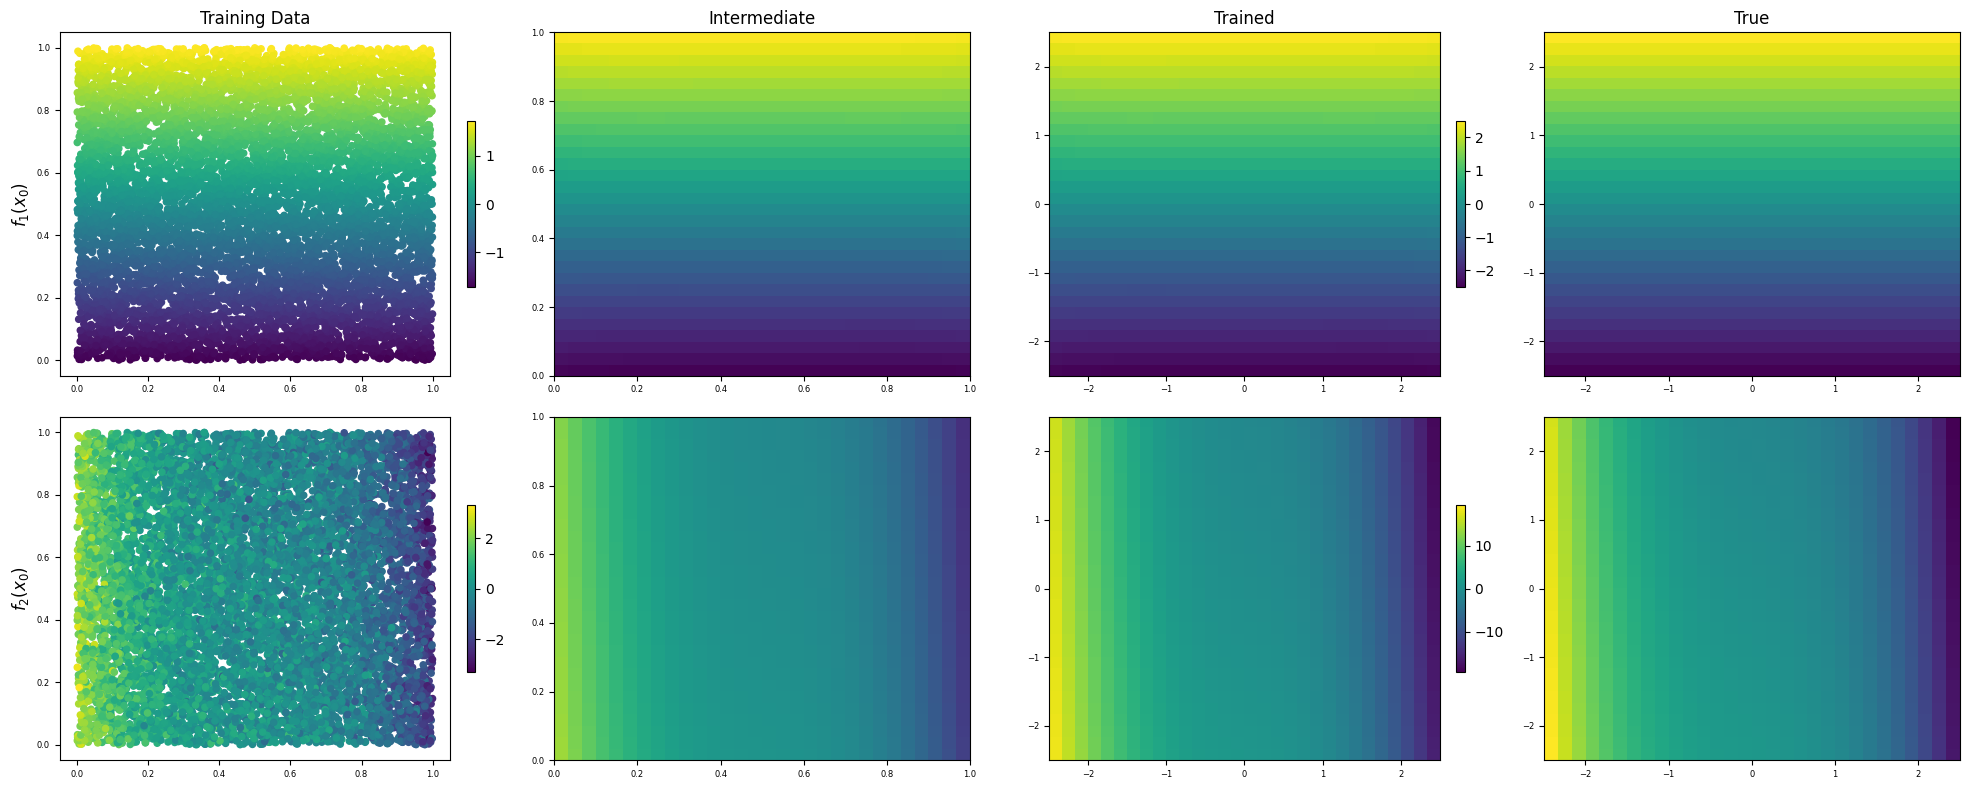

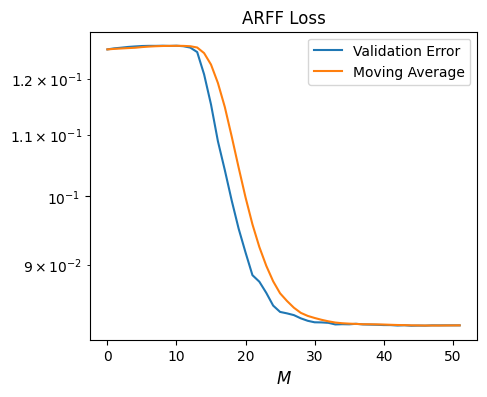

diff epoch: 76


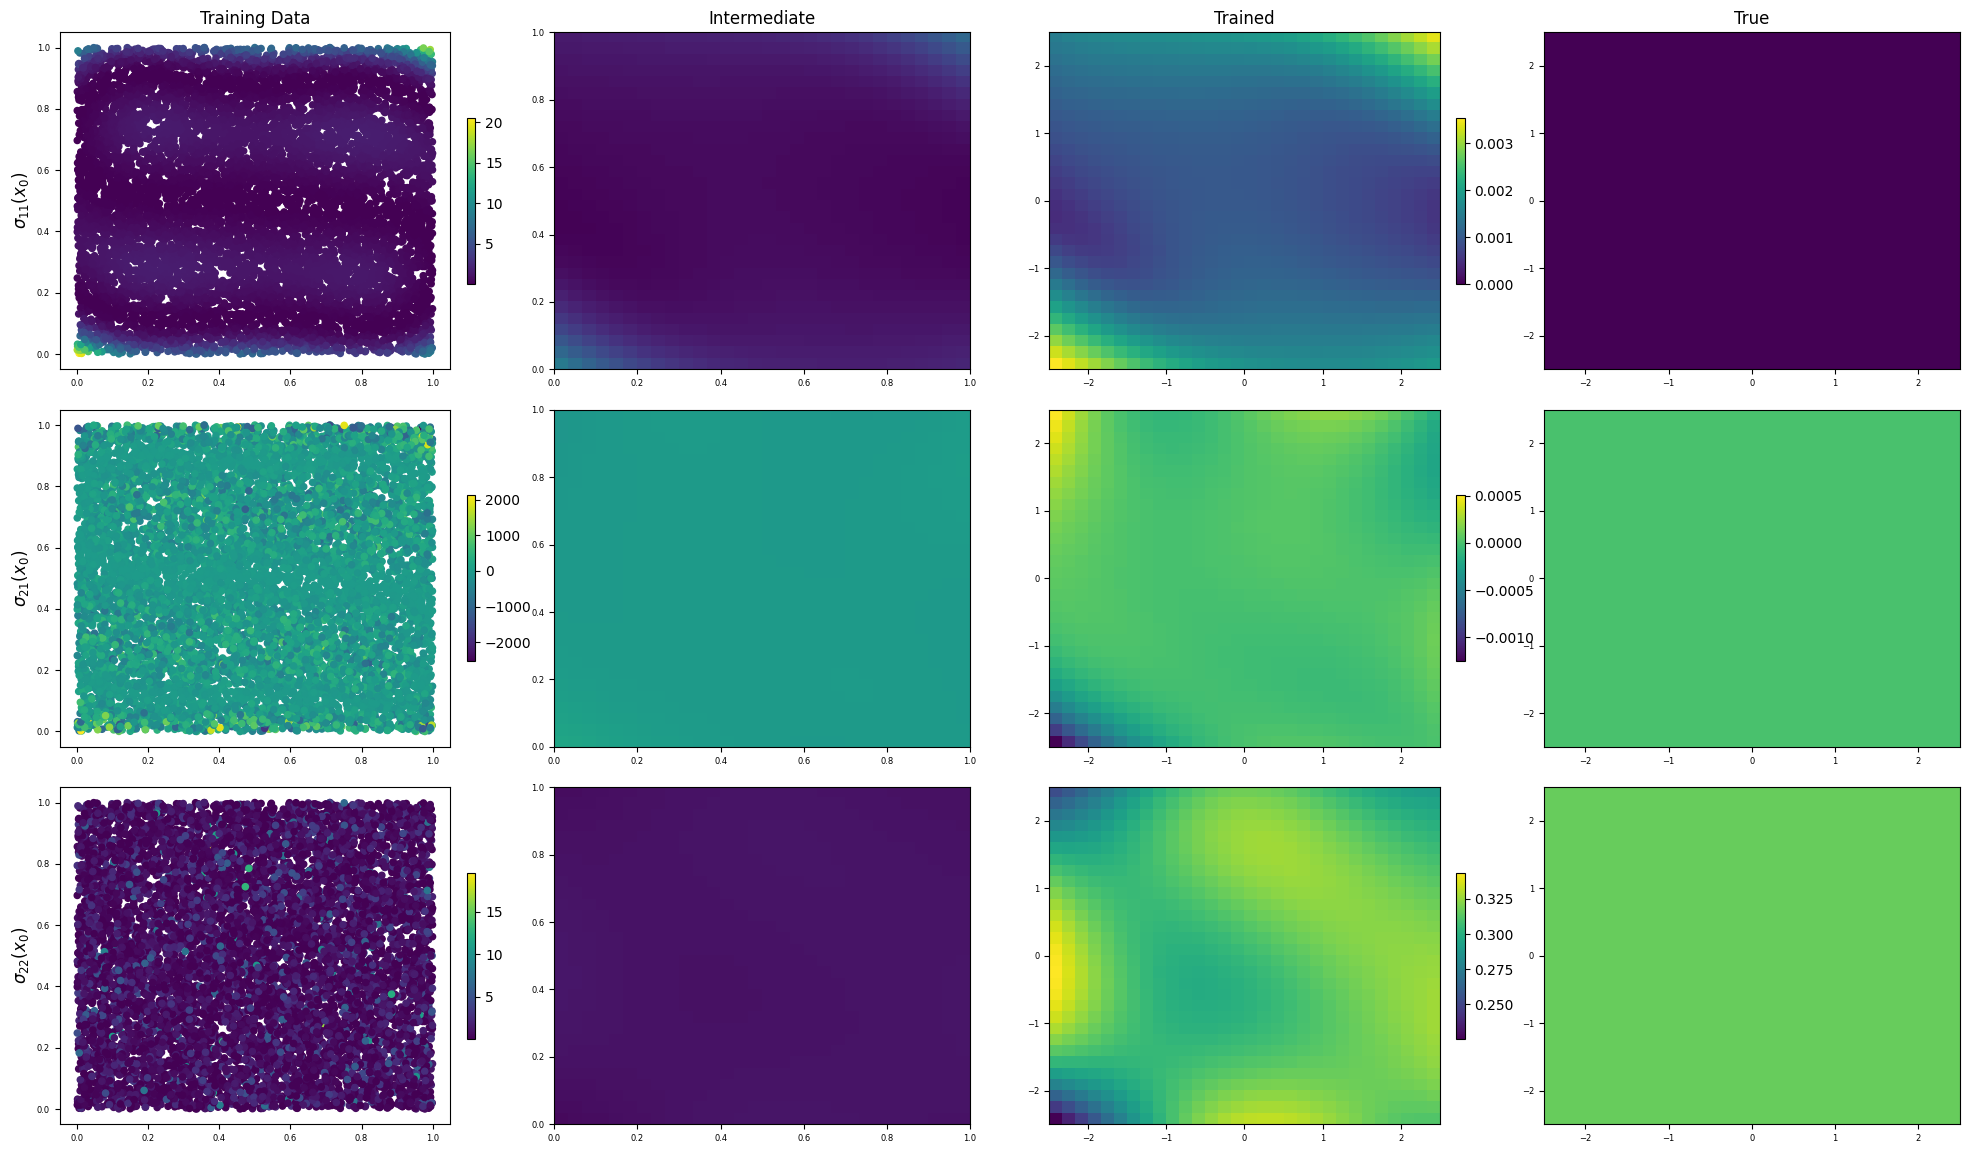

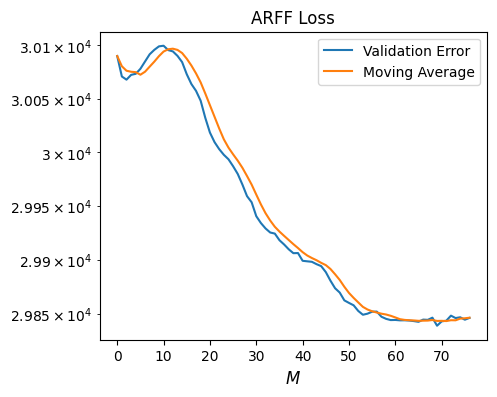

 Observed loss: -6.439352989196777
 Observed validation loss: -6.434382438659668


In [89]:
No_of_tests = 1
training_time = np.zeros(No_of_tests)
val_loss = np.zeros(No_of_tests)

for i in range(No_of_tests):
    SAT = SDEAMTrain(n_dimensions=n_dimensions)
    hist = SAT.train_model(drift_param, diff_param, true_drift_diffusivity, x_data, y_data, step_sizes=step_sizes, validation_split=validation_split, AM_validation_split=AM_validation_split, plot=True)
    training_time[i] = hist.history["training_time"]
    val_loss[i] = hist.history["val_loss"]

figures_per_row 2


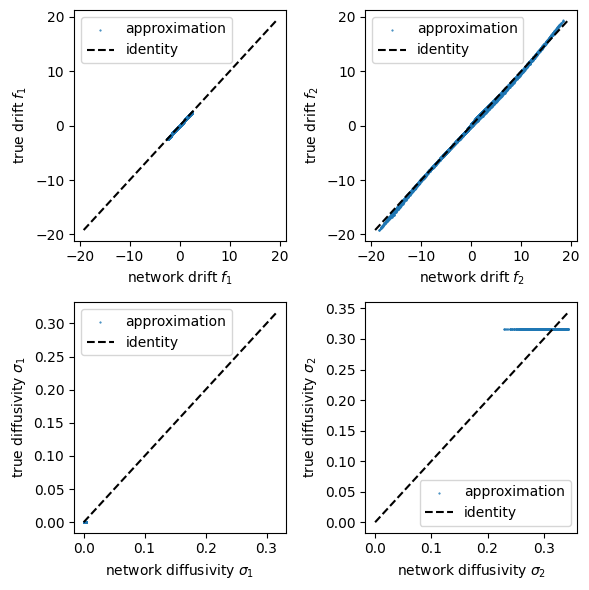

In [96]:
rng = np.random.default_rng(random_seed)

ax = plot_results_functions(SAT.drift_diffusivity, true_drift_diffusivity,
                            x_data, y_data, rng,
                            data_transform_network=None,
                            data_transform_true=None)